In [149]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import wikipedia
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer 
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC

Let's try to get some model iterations going on, and let's improve that accuracy!

We left off with a decision tree classifier

In [61]:
df = pd.read_csv('../data/final_plots.csv')
df.sample(5)

,Unnamed: 0,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,plots
963,2130,Skylanders: Spyro's Adventure,X360,2011.0,Action,Activision,0.53,0.34,0.00,0.10,0.97,78.0,35.0,5.2,53.0,Toys for Bob,E10+,The game begins with a village in Skylands bei...
2155,5186,Monster Rancher 3,PS2,2001.0,Simulation,Tecmo Koei,0.11,0.09,0.14,0.03,0.36,77.0,13.0,8.5,23.0,Tecmo,E,This game uses cel-shaded graphics to give the...
2853,7260,Tropico 3,X360,2009.0,Strategy,Kalypso Media,0.15,0.02,0.03,0.01,0.22,75.0,33.0,6.6,22.0,Haemimont,T,Players begin having seized power of the Carib...
4056,11335,How to Train Your Dragon 2,WiiU,2014.0,Adventure,Little Orbit,0.03,0.05,0.00,0.01,0.08,47.0,4.0,4.9,7.0,Torus Games,E10+,Five years after the Viking villagers of Berk ...
50,106,Tekken 3,PS,1998.0,Fighting,Sony Computer Entertainment,3.27,2.22,1.40,0.29,7.16,96.0,15.0,9.1,367.0,Namco,T,Fifteen years after the King of the Iron Fist ...


In [69]:
def success(value):
    '''
    function for binning the critic scores
    '''
    
    if value > 60:
        if value > 75:
            return 2
        return 1
    return 0

In [70]:
df['success'] = df.Critic_Score.apply(success)

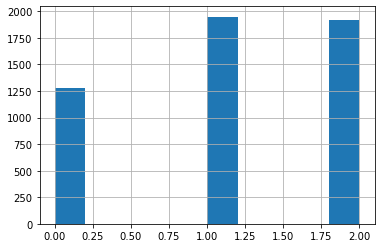

In [35]:
df.success.hist()

In [36]:
y = df[['success']]
X = df[['plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [39]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

In [40]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tf, y_train)

DecisionTreeClassifier()

In [44]:
print('train acc: ', dt.score(X_train_tf, y_train))
print('test acc: ', dt.score(X_test_tf, y_test))

train acc:  0.9258491055224267
test acc:  0.5917573872472783


Alright so we've got our decision tree classifier, and surprise! we're way overfit

It's not a bad place to start though, almost 60% accuracy with a 3-class classifier

### Model 2

What I'd like to do next is to lemmatize the words before vectorizing. Undoubtedly we're getting some different conjugations and word tenses muddying up our data. We'll modify our clean_text function to lemmatize the words as well

In [52]:
def clean_text(text):
    import string
    wnl = WordNetLemmatizer()
    words = [''.join(ch for ch in s if ch not in string.punctuation) for s in text.split()]
    words = [wnl.lemmatize(word) for word in words]
    return ' '.join(words).lower()

In [62]:
df.plots = df.plots.apply(clean_text)
df.plots[100]

'princess peach is held captive in her castle by bowser bowser jr and the koopalings who invade and use a giant mechanical arm to throw mario luigi and two toads far away mario and friend must now travel across this new land returning to peachs castle in order to save her on the way they encounter seven koopalings each controlling their own world plus kamek nabbit bowser jr and many minor monster like goomba by conquering them they get closer to peachs castle which ha been transformed into an evil reflection of bowser by defeating bowser the castle return to normal as the hero celebrate bowser jr and the koopalings attempt to escape almost leaving bowser behind he manages to jump up onto the airship but his weight cause it to crash and they are forced to flee on bowser jrs koopa clown car'

Now there's no punctuation, and the words have been slightly lemmatized...? 

**note** I'm not too happy with the lemmatizer, words like 'conquering' 'returning' 'held', I thought it would deal with those

Let's try our decision tree again

In [75]:
y = df[['success']]
X = df[['plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [97]:
tf = TfidfVectorizer(stop_words='english', max_features=2000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [98]:
print('train acc: ', dt.score(X_train_tf, y_train))
print('test acc: ', dt.score(X_test_tf, y_test))

train acc:  0.9211822660098522
test acc:  0.6049766718506998


Grabbing that one percent, alright

### Model 3

Let's try a naive bayes classifier...the big guns

In [111]:
nb = MultinomialNB()

In [112]:
nb.fit(X_train_tf, y_train.values.ravel())

MultinomialNB()

In [113]:
print('train acc: ', nb.score(X_train_tf, y_train))
print('test acc: ', nb.score(X_test_tf, y_test))

train acc:  0.6585429089966295
test acc:  0.5505443234836703


So that's worse, I think because the multinomial naive Bayes algorithm is best suited to deal with the integer features of count-vectorized language.

let's just see if that helps

In [120]:
cv = CountVectorizer(max_features=2000)
X_train_cv = cv.fit_transform(X_train.plots)
X_test_cv = cv.transform(X_test.plots)

In [121]:
nb.fit(X_train_cv, y_train.values.ravel())

MultinomialNB()

In [122]:
print('train acc: ', nb.score(X_train_cv, y_train))
print('test acc: ', nb.score(X_test_cv, y_test))

train acc:  0.5421311900440757
test acc:  0.4665629860031104


*It was worth a shot, alright!?*

### Model 4

Now I'd like to try a random forest classifier....the *really* big guns

First we'll just see what the vanilla classifier can do here

In [141]:
tf = TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1,2))
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tf, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced')

In [142]:
print('train acc: ', rf.score(X_train_tf, y_train))
print('test acc: ', rf.score(X_test_tf, y_test))

train acc:  0.9211822660098522
test acc:  0.6158631415241057


Eeking out those percentages once again


In [147]:
svc = SVC()
svc.fit(X_train_tf, y_train.values.ravel())

SVC()

In [148]:
print('train acc: ', rf.score(X_train_tf, y_train))
print('test acc: ', rf.score(X_test_tf, y_test))

train acc:  0.9211822660098522
test acc:  0.6158631415241057


### Time to blow it up with a *mean* grid search

In [150]:
params = {'C': [.2, .5, 1],
          'kernel': ['poly', 'linear'],
          'class_weight': ['balanced', None]}
svc = SVC()
gs = GridSearchCV(svc, params)


In [151]:
gs.fit(X_train_tf, y_train.values.ravel())

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.2, 0.5, 1], 'class_weight': ['balanced', None],
                         'kernel': ['poly', 'linear']})

In [156]:
gs.best_params_

{'C': 1, 'class_weight': None, 'kernel': 'poly'}

In [161]:
gs.best_estimator_.score(X_test_tf, y_test)

0.6181959564541213

In [173]:
feature_array = np.array(tf.get_feature_names())
tfidf_sorting = np.argsort(X_train_tf.toarray()).flatten()[::-1]

n = 100
top_n = feature_array[tfidf_sorting][:n]

In [174]:
top_n

array(['jones', 'character', 'indiana', 'lego', 'movie', 'custom',
       'creation', 'player', 'story', 'mode', 'playable', 'ability',
       'game', 'college', 'played', 'interact', 'star wars',
       'playable character', 'story mode', 'wars', 'extra', 'environment',
       'added', 'film', 'new', 'option', 'access', 'allows player',
       'star', 'scene', 'like', 'gameplay', 'level', 'library', 'mission',
       'ark', 'allows', 'solo', 'hub', 'henry', 'holy', 'mix', 'showdown',
       'different', 'spider', 'frozen', 'play', 'snake', 'play mode',
       'melee', 'doom', 'unlockable', 'cutscene', 'developer',
       'game story', 'player chooses', 'traditional', 'trip', 'choosing',
       'chapter', 'puzzle', 'art', 'serf', 'make', 'colonel', 'use',
       'fear', 'ride', 'limited', 'section', 'storyline', 'range',
       'required', 'featured', 'animal', 'chooses', 'player use',
       'game ha', 'figure', 'movement', 'total', 'divided', 'standard',
       'wall', 'content', 'br